In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("pocket_planet_fa25.ipynb")

# Pocket Planet

## Introduction

In this lab, we'll build a world using probability! To do so, we will set up a world and treat plants as particles. At each time step, these plants will reproduce and compete with each other for the limited space, in the process passing on the fitter genes.

Below is an example of such a simulation we will build.

<div>
  <table>
    <tr>
      <td>
        <img src="images/cover_photo.png" width="400"/>
      </td>
    </tr>
  </table>
</div>

In [2]:
# If modules have not been installed yet:

%pip install -r requirements.txt

# Restart kernel afterwards, if needed

Note: you may need to restart the kernel to use updated packages.


In [3]:
from itertools import product
import numpy as np
import scipy
import os
import random


In [4]:
%load_ext autoreload
%autoreload 2
from pocket_planet_utils import *

## Part 1: Generating the World

The first step to our simulation is to build the world. But how do we generate elevations and lanscapes that look realistic? 

Let's first define our world. We will design our world to be a 100 pixel by 100 pixel square with 7 terrains: ocean, shallows, sand, dirt, inland, mountain, and snow. Each terrain will corresponds to an elevation range, and so to generate our world, we just need to generate 2-dimensional heigh coordinates. The following pictures show what the elevations and worlds might end up looking like.

<div>
  <table>
    <tr>
      <td>
        <img src="images/elevations.png">
      </td>
      <td>
        <img src="images/uninhabited.png">      
      </td>
    </tr>
  </table>
</div>


How do we generate worlds? A good first guess is to just randomly sample! This is known as "Value Noise." Here are the steps:
1. Create a grid of random values at integer lattice points.
2. For any input point (x, y), find the surrounding grid corners.
3. Interpolate the corner values 
4. Clip the noise between 0 and 1, to ensure it is a valid distribution.

For the "interpolation" step, you should use scipy.ndimage.zoom -- you can look at documentation for this function online!

In [5]:
def value_noise():
    #TODO: Implement Value Noise. First, generate a random 10x10 grid via numpy.random.rand. Then, generate interpolations via scipy.ndimage.zoom with order 5 and the necessary sca1ing factor.
    #Interpolation can sometimes add noise greater than 1. Be sure to clip the noise between (0.0, 1.0)
    noise = np.random.rand(10,10)
    perlin_noise = scipy.ndimage.zoom(noise, zoom=10, order=5)
    perlin_noise = np.clip(perlin_noise, 0, 1)
    return perlin_noise


In [6]:
grader.check("value_noise")

value_noise results: All test cases passed!

This is what your world with value noise looks like!

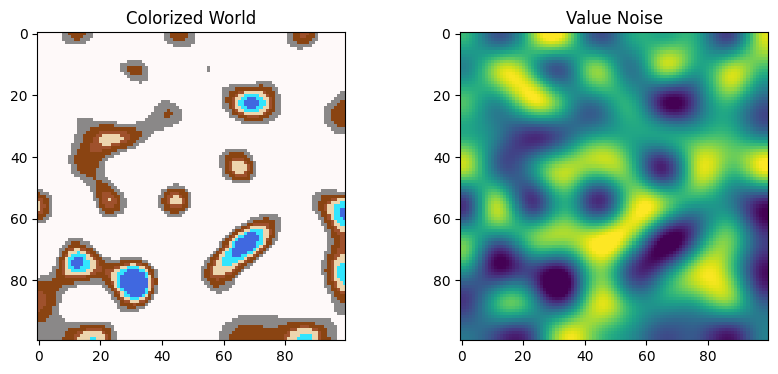

In [7]:
noise = value_noise()
ground_elevations = np.array([0.01, 0.075, 0.15, 0.2, 0.3, 0.4, 1.0])
visualize_height_values(ground_elevations, noise, "Value Noise")


It works, but it seems unrelalistic, with random hotspots and not much water! Can we do better? lot of research has been poured into this, and one method which has been successful is Perlin noise, which you can rea more about on [Wikipedia](https://en.wikipedia.org/wiki/Perlin_noise) and this [blog post](https://flafla2.github.io/2014/08/09/perlinnoise.html). The method is used in both animated movies and Minecraft, and we will use it too in this lab. Below you will find images perlin noise in 1, 2, and 3 dimensions.


<div>
  <table>
    <tr>
      <td>
        <img src="images/perlin_noise.png", width=875px>
      </td>
    </tr>
 </table>
</div>

We will implement Perlin noise in this section!

Now, to generate the functions of each frequency, we create a $(l+1) \times (l+1)$ array of unit gradient vectors (kind of like what is shown on the left), where $l$ is the maximum frequency (in the above picture, it is 128). Each square in this grid has 4 gradient vectors on the corner, as shown on the right.

<div>
  <table>
    <tr>
      <td>
        <img src="images/perlin_gradients.png"style="background-color: white; padding: 10px">
      </td>
      <td>
        <img src="images/perlin_grad_4.png"style="background-color: white; padding: 10px">
      </td>
    </tr>
 </table>
</div>

To do this, we must first generates $n$-dimensional gradient vectors with unit length. 

There are many different ways we can compute the gradient vector.  Classically, Each gradient vector is computed by independently sampling from $\mathcal{N}(0, I_n)$. For the sake of the lab, please also implement sampling from a ${Exp}(\lambda)$ distribution. Then normalize it to be unit length.

We let $\lambda$ be an input to the function. The possible values of distribution are ["normal", "exponential"]

In [8]:
def generate_gradient(n, distribution, lam):
    if distribution == 'normal':
        mu = 0 
        var = 1
        normal_dist = scipy.stats.norm(loc=mu, scale=np.sqrt(var))
        vec = normal_dist.rvs(n)
    else: 
        exp_dist = scipy.stats.expon(scale=(1 / lam))
        vec = exp_dist.rvs(n)

    return vec / np.linalg.norm(vec)


In [9]:
grader.check("generate_gradients")

generate_gradients results: All test cases passed!

The cell below, generates the array of gradients for the 2D case as a NumPy array with shape $(l+1, l+1, 2)$.

In [10]:
def generate_corner_gradients(l, distribution, lam):
    corners = np.array([generate_gradient(2, distribution, lam) for _ in range((l+1) * (l+1))])
    corners = corners.reshape(l+1, l+1, 2)
    return corners

Now comes the interpolation part. For a general point in $[0, l] \times [0, l]$, we find which square it lies by looking at the floor and ceiling of its x and y coordinates. Then, we compute the dot product of the gradient vector and "delta" vector for each of the 4 corners of the square it lies in. The "delta" vectors for a point in one of the $l \times l$ squares is shown below.

<div>
  <table>
    <tr>
      <td>
        <img src="images/perlin_dist_4.png", style="background-color: white; padding: 10px">
      </td>
    </tr>
 </table>
</div>

In [11]:
def compute_dot_products(gradients, x, y):
    floor_x, floor_y = int(x), int(y)
    ceil_x, ceil_y = floor_x + 1, floor_y + 1
    corner_coords = np.array([[[floor_x, floor_y], [ceil_x, floor_y]],
                              [[floor_x, ceil_y], [ceil_x, ceil_y]]])
    corner_gradients = gradients[floor_y: ceil_y+1, floor_x: ceil_x+1]
    delta = np.array([x, y]) - corner_coords
    return np.sum(corner_gradients * delta, axis=2)

Now we want to interpolate a value at (x, y) given the values at the 4 corners. It turns out a nice function for doing this involves a degree-5 polynomial.

In [12]:
def smooth_interp(t, a, b):
    smooth_t = 6*t**5 - 15*t**4 + 10*t**3
    return (1 - smooth_t) * a + smooth_t * b

Bilinearly interpolate.

In [13]:
def interpolate(dots, x, y):
    dx = x - np.floor(x)
    dy = y - np.floor(y)
    interp1 = smooth_interp(dx, dots[0, 0], dots[0, 1])
    interp2 = smooth_interp(dx, dots[1, 0], dots[1, 1])
    interp = smooth_interp(dy, interp1, interp2)
    return interp

Now to put everything together, even though our array of gradients corresponds to a point in $[0, l] \times [0, l]$, each pixel in our 100 x 100 square world will just correspond to a point $[0, 1] \times [0, 1]$. However, we will still use the rest of the array as we will generate the higher frequency functions by mapping a point $x, y \in [0, 1] \times [0, 1]$ to $f \cdot x, f \cdot y \in [0, l] \times [0, l]$, where $f$ is the frequency.

In [14]:
def generate_world(size=100, l=4, distribution = "normal", lam = 1e-9):
    grad = generate_corner_gradients(2 ** l + 1, distribution, lam)
    units = np.linspace(0, 1, size)
    rescale_factor = (2 ** 0.5)
    grid = np.zeros((size, size))
    for i, x in enumerate(units):
        for j, y in enumerate(units):
            for log_f in range(l):
                f = 2 ** log_f
                amp = 1 / f
                new_x = x * f
                new_y = y * f
                dots = compute_dot_products(grad, new_x, new_y)
                val = interpolate(dots, new_x, new_y)
                rescaled_val = val * rescale_factor
                grid[j][i] += rescaled_val * amp
    grid /= 2 - 2 ** (1 - l)        
    return grid

You may have to run this cell and the cell below several times to get the world you want.

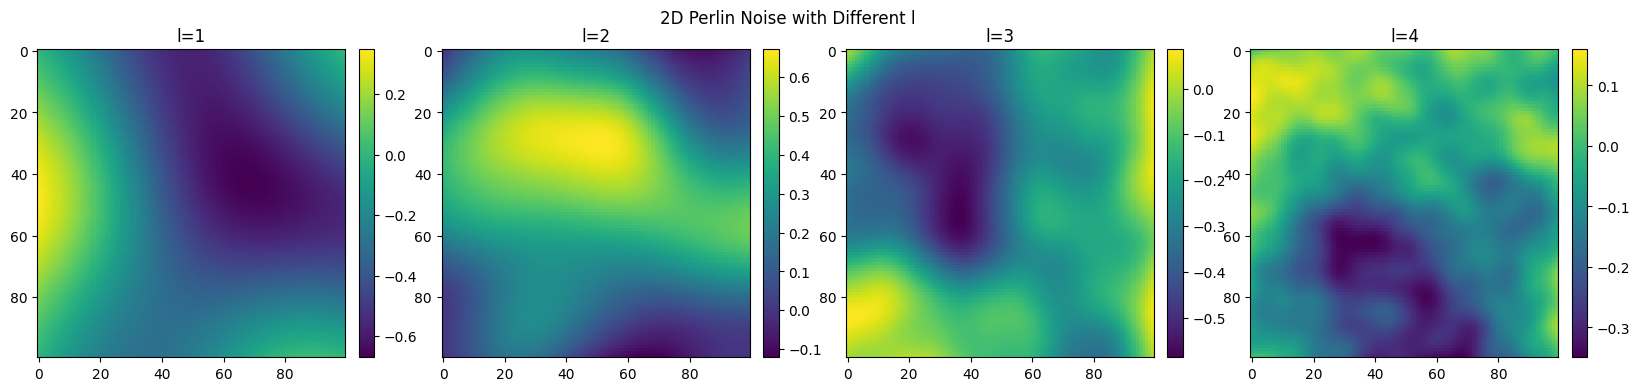

In [15]:
fig, ax = plt.subplots(1, 4, figsize=(20, 4))
test_worlds = []
fig.suptitle('2D Perlin Noise with Different l')
for l in range(4):
    world = generate_world(l=l+1)
    test_worlds.append(world)
    ax[l].set_title(f'l={l+1}')
    im = ax[l].imshow(world)
    fig.colorbar(im, ax=ax[l], fraction=0.046, pad=0.04)

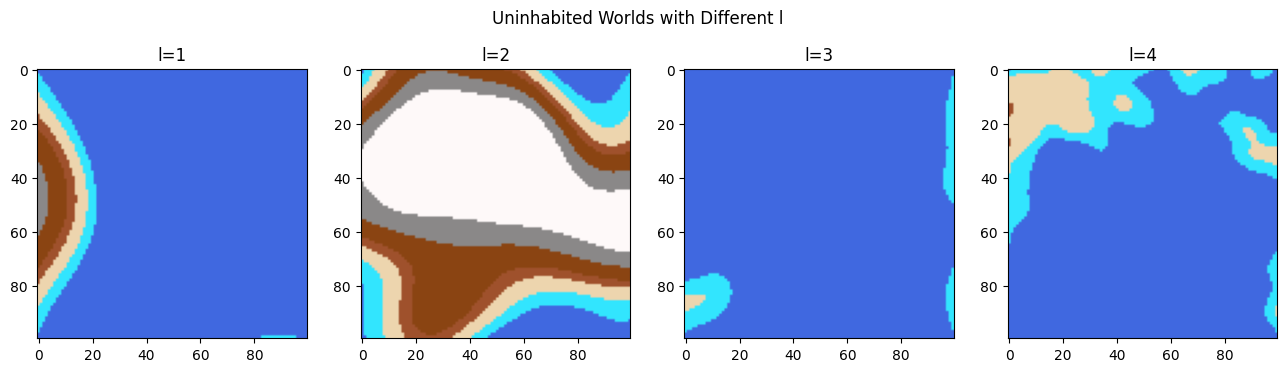

In [16]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle('Uninhabited Worlds with Different l')
for l in range(4):
    uninhabited_world = get_uninhabited_world(test_worlds[l])
    ax[l].set_title(f'l={l+1}')
    im = ax[l].imshow(uninhabited_world)

Use the knobs below to visualize worlds with defined height vectors for the enviorment types.

In [17]:
import ipywidgets as widgets
from ipywidgets import interact

grid = generate_world()

@interact(ocean=h_o,shallows=h,beach=h,dirt=h,inland=h,mountain=h)
def toggle_ground_heights(ocean=0.01,
                          shallows=0.075,
                          beach=0.15,
                          dirt=0.2,
                          inland=0.3,
                          mountain=0.4,):
    heights = np.array([ocean, shallows, beach, dirt, inland, mountain, 1])
    visualize_height_values(heights, grid, "Perlin Noise")

interactive(children=(FloatSlider(value=0.01, description='ocean', max=0.5, step=0.05), FloatSlider(value=0.07…

We now might wonder how the type of distribution the gradient is drawn from changes the world! Let's simulate $100$ worlds from $N(0, I_n)$ and $Exp(10^{-9})$, below:

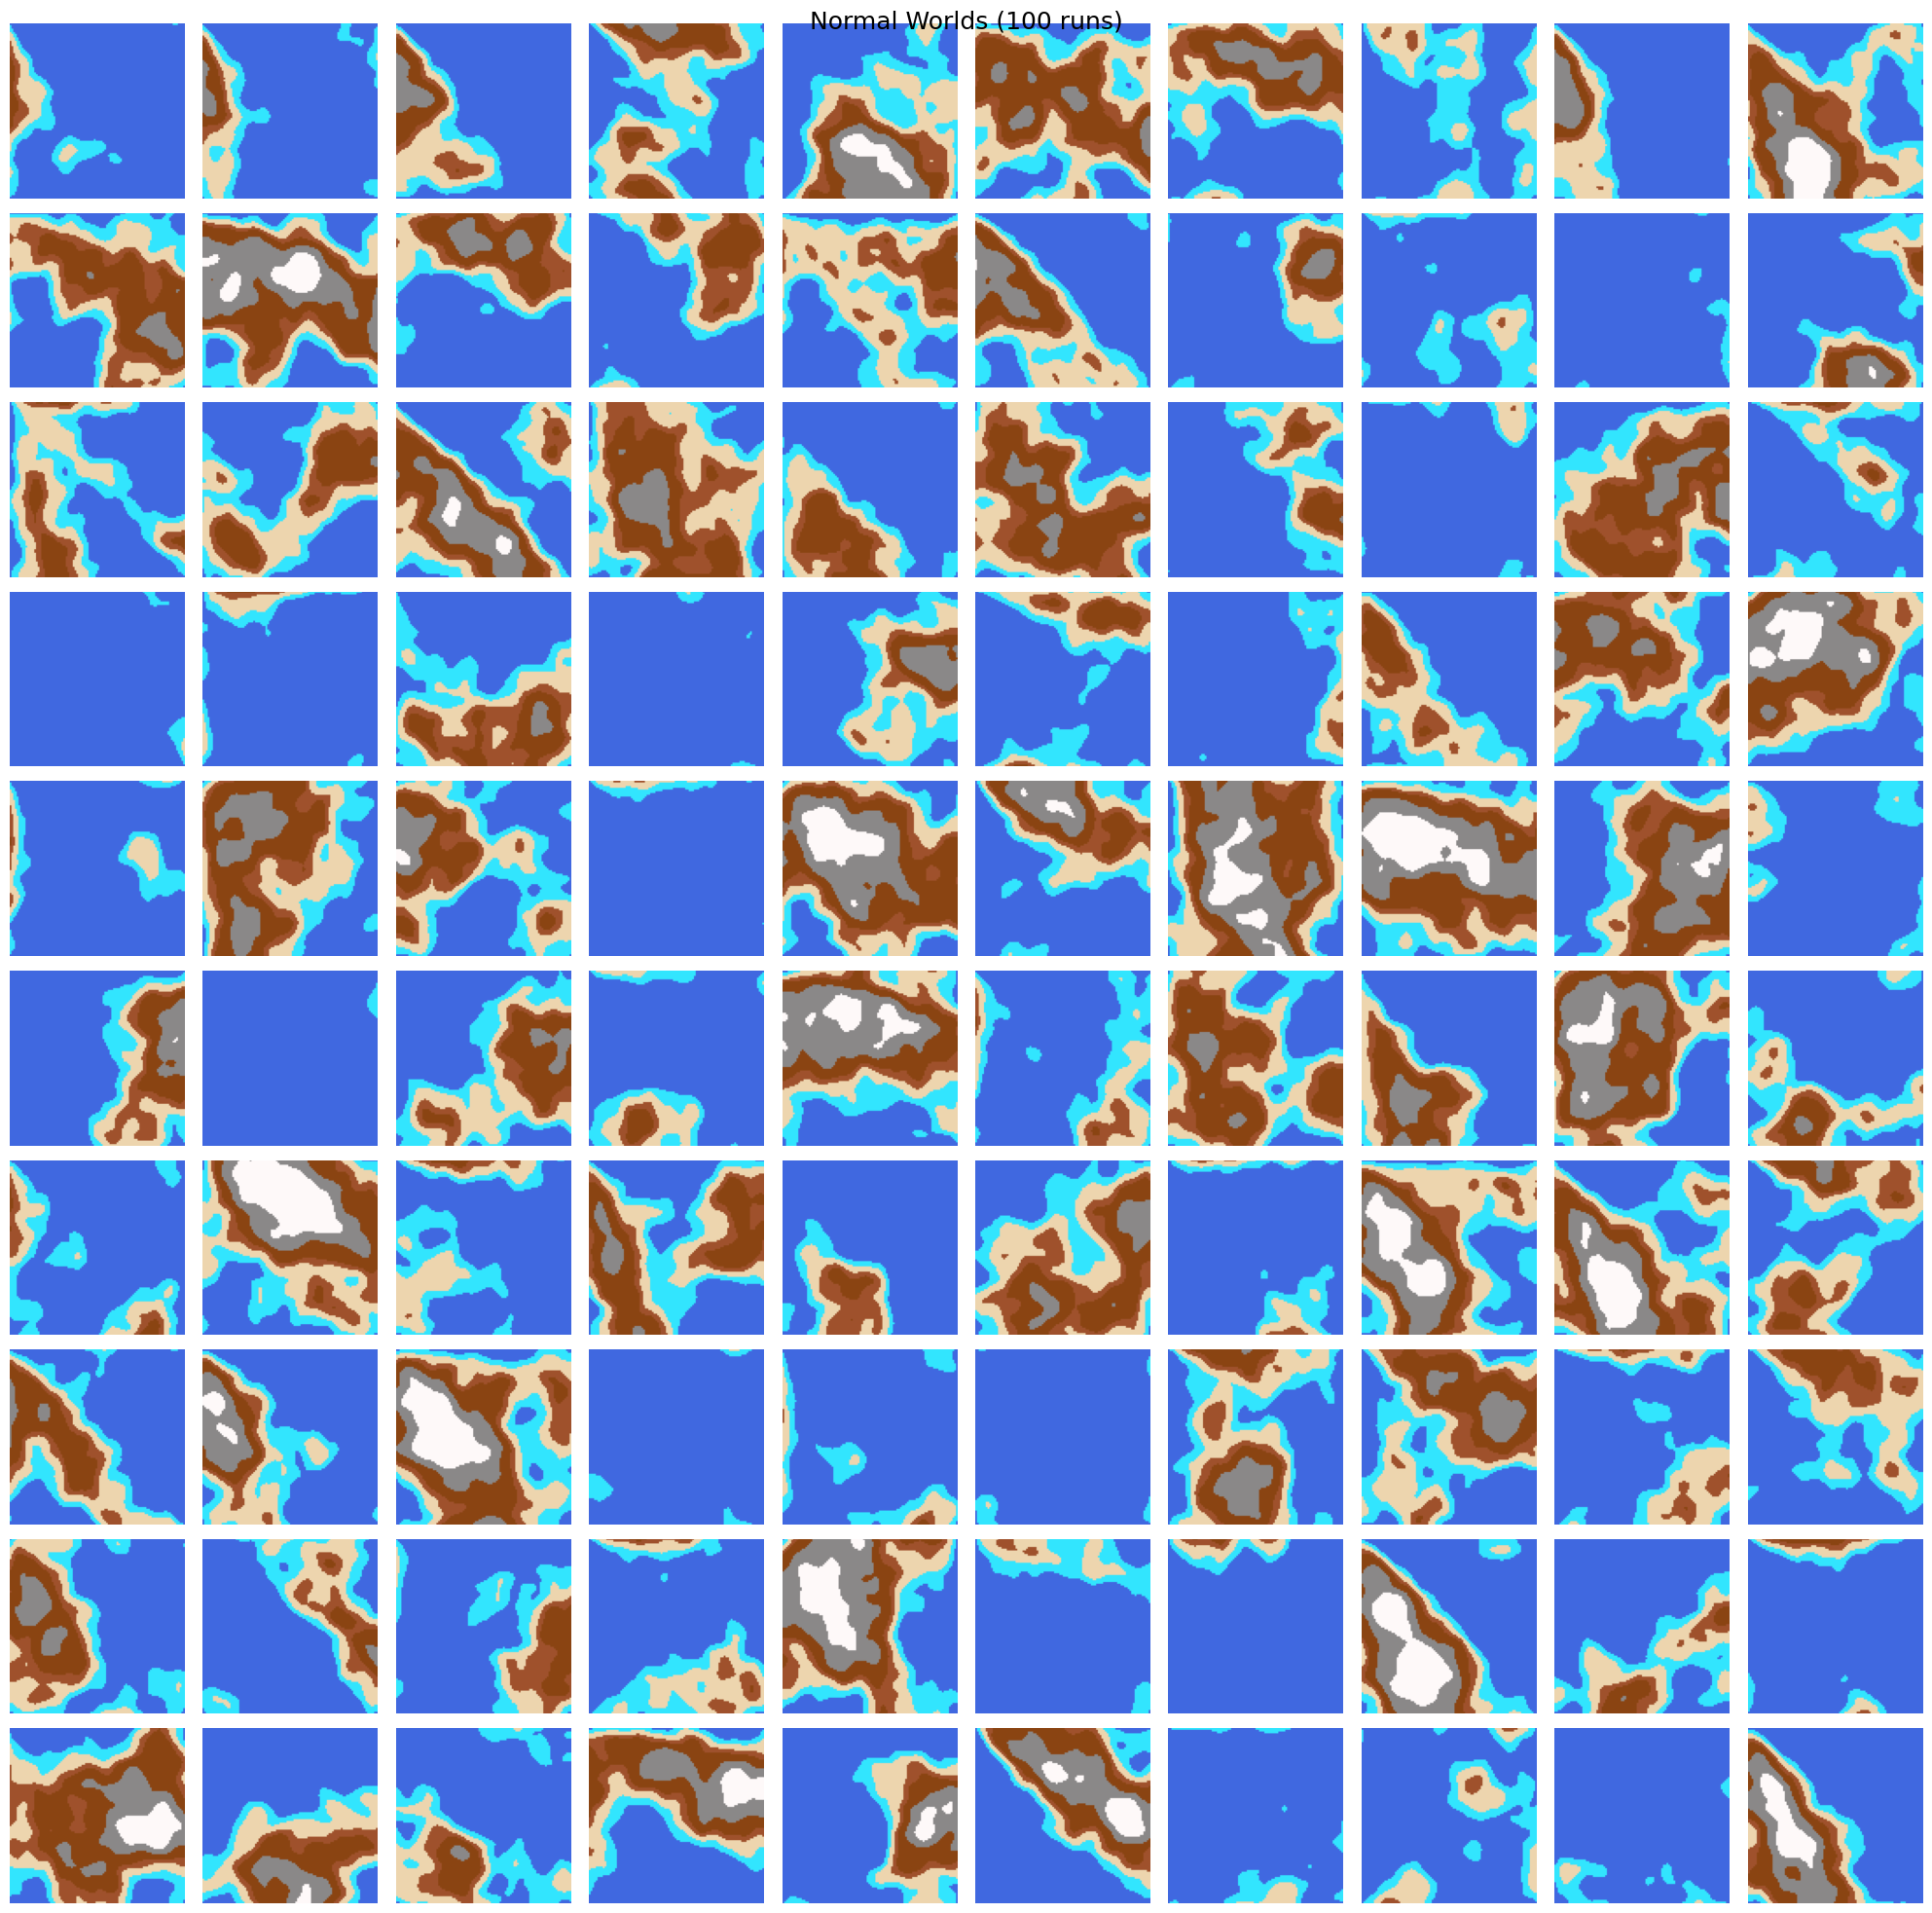

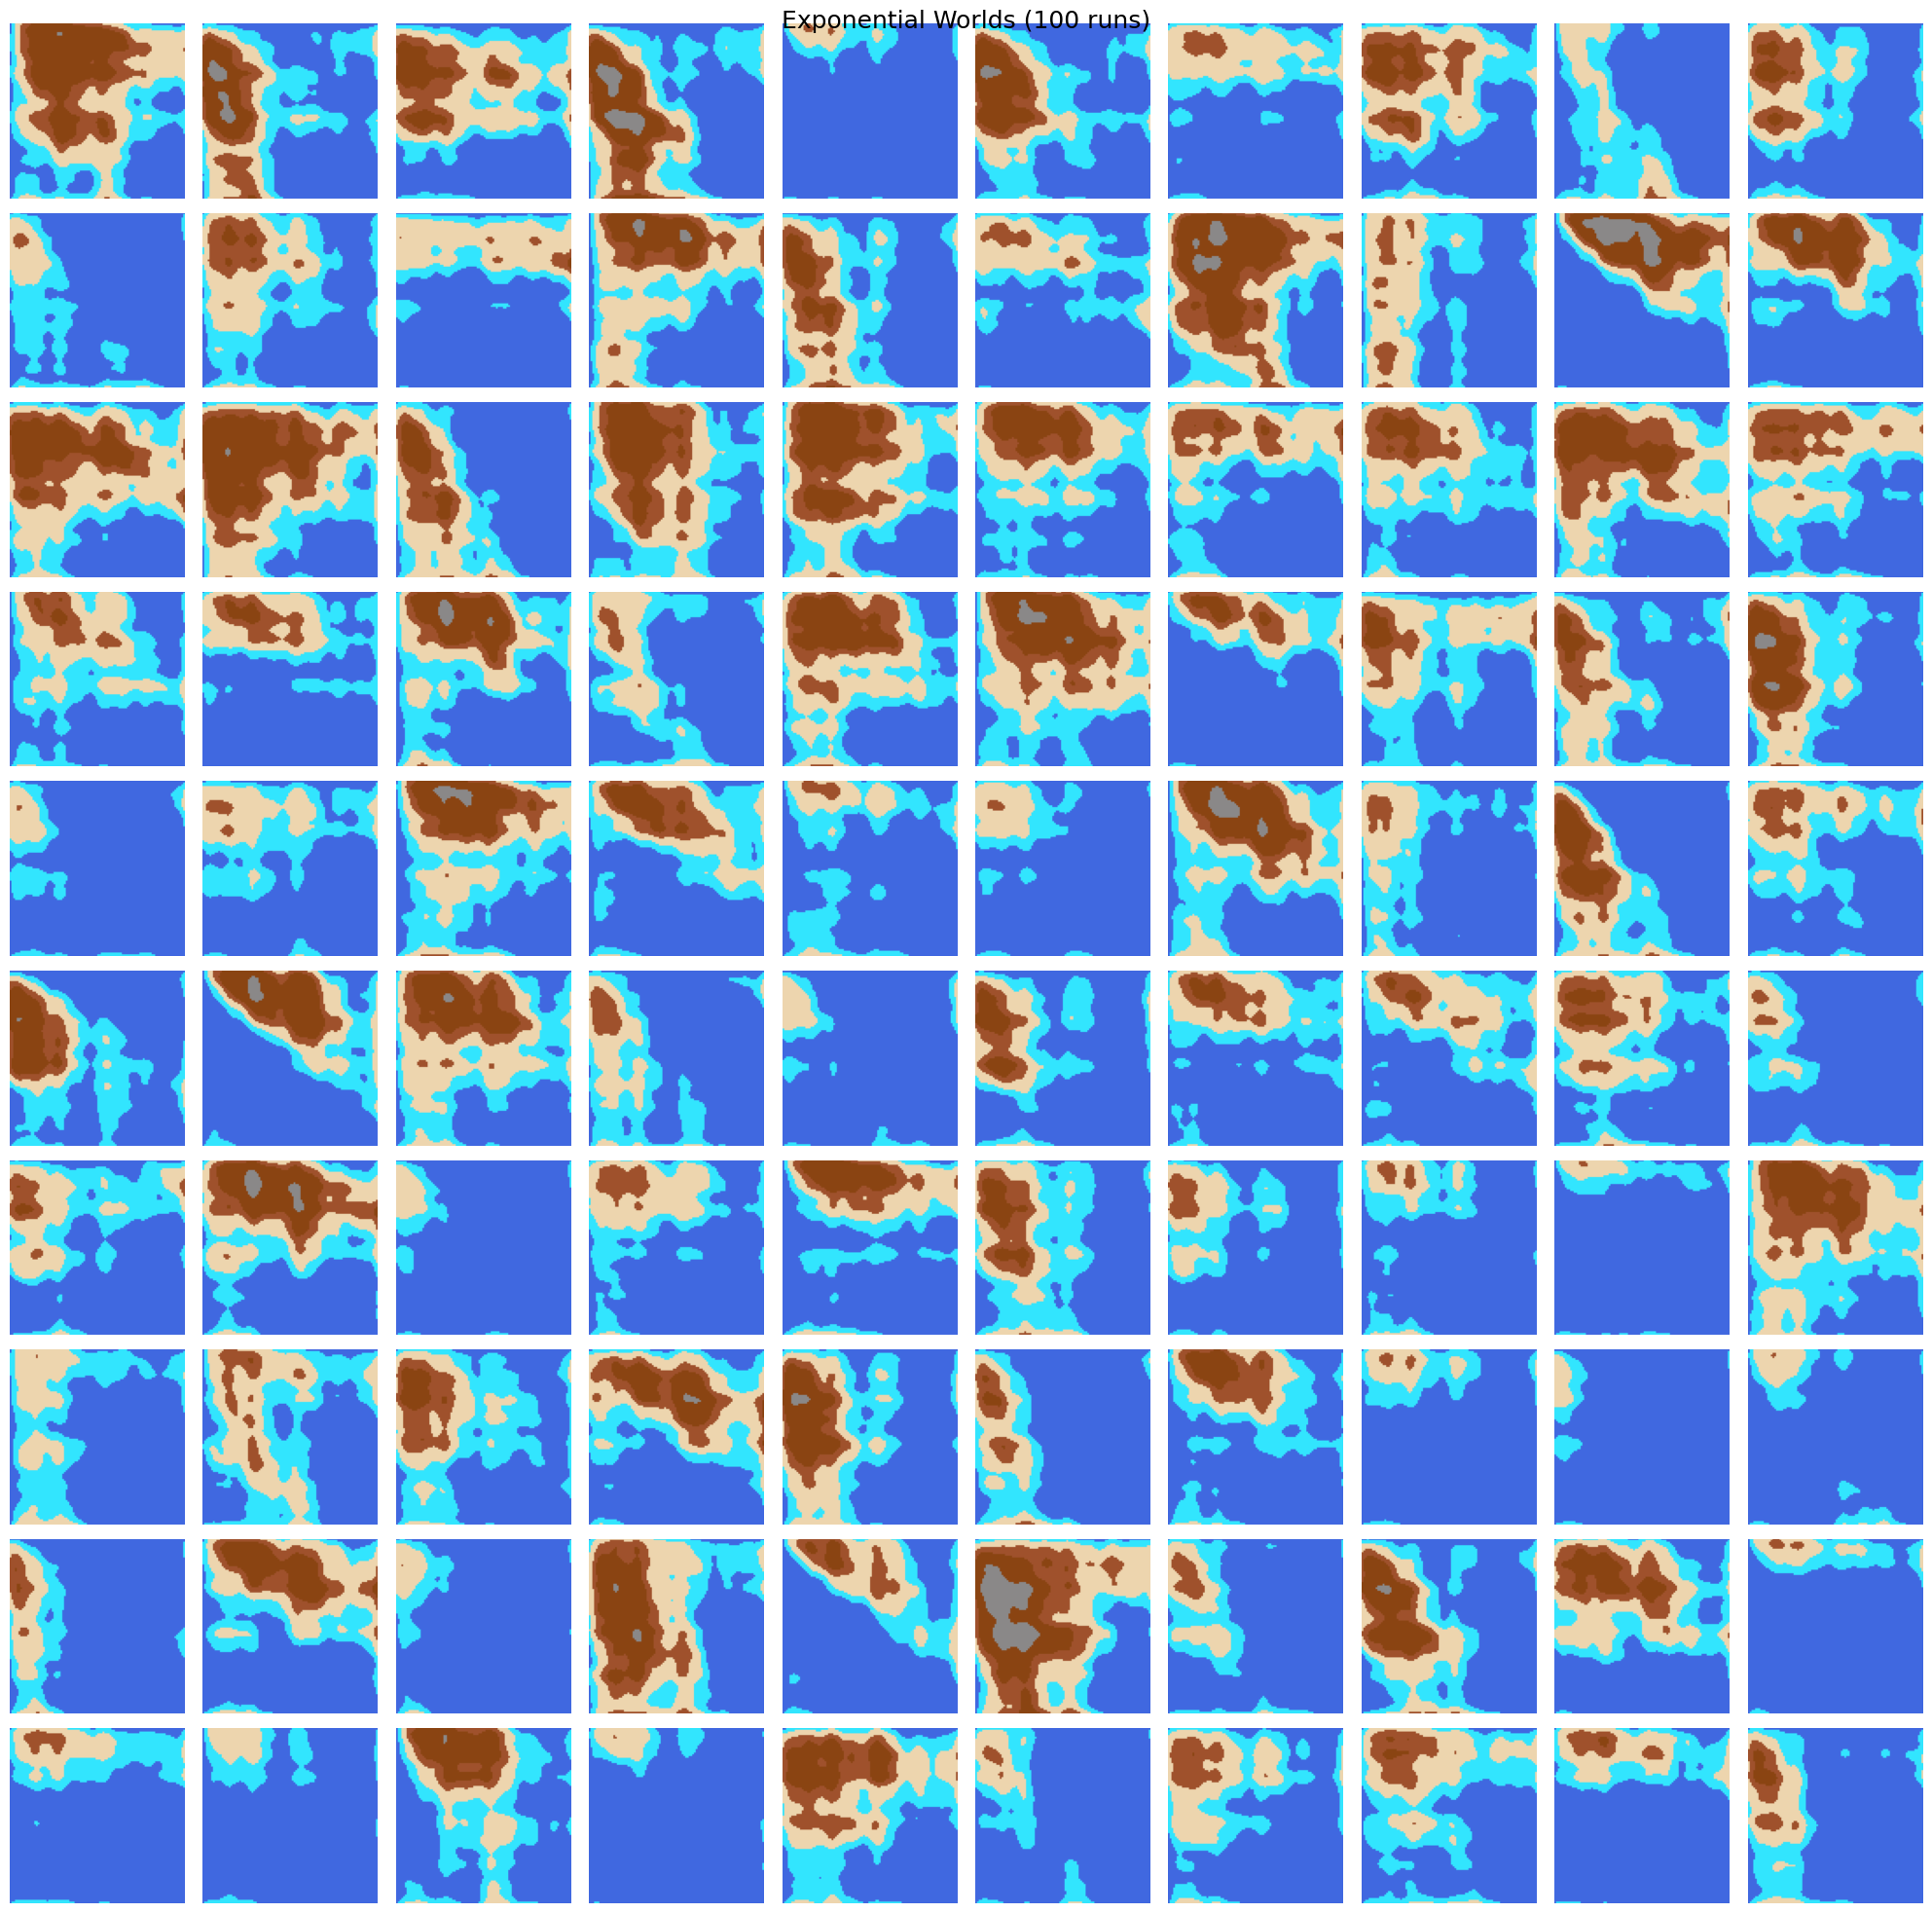

In [18]:
def plot_multiple_worlds(distribution, lam=None, runs=100, l=4, size=100):
    worlds = []
    for _ in range(runs):
        if distribution == "exponential":
            w = get_uninhabited_world(generate_world(l=l, distribution=distribution, lam=lam, size=size))
        else:
            w = get_uninhabited_world(generate_world(l=l, distribution=distribution, size=size))
        worlds.append(w)

    # Build montage: sqrt(runs) × sqrt(runs) grid
    grid_dim = int(np.sqrt(runs))
    fig, axes = plt.subplots(grid_dim, grid_dim, figsize=(20, 20))
    fig.suptitle(f"{distribution.capitalize()} Worlds ({runs} runs)", fontsize=18)

    for i, ax in enumerate(axes.flat):
        im = ax.imshow(worlds[i], cmap="viridis")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# # Generate 100 runs for each
plot_multiple_worlds("normal", runs=100)
plot_multiple_worlds("exponential", lam=1e-9, runs=100)


<!-- BEGIN QUESTION -->

## WRITEN QUESTIONS
[TODO]: Answering on gradescope
1) Why do you think Perlin Noise works better than Value Noise?
2) Do you notice anything different in the type of terrian when you change the gradient generation mechanism from from Normal to Exponential? Are any types missing? Why do you think this is?
3) Do you notice anything different in the locations of terrian when you change the gradient generation mechanism from from Normal to Exponential? Do they cluster in a specific location? Why do you think this is?


Here are some hints for answering the "why" of questions 2 and 3:

- The exponential distribution only outputs positive values, while the normal distribution can output both positve and negative values. 
- The process for generating grids involves taking the dot product between the draws and the direction vector to a given point. Consider what happens if the draws are all positive versus if they are more evenly distributed
- Recall that we normalize our distribution so that the samples have a norm of 1. If we consider sampling a distribution $X_i$ $n$ times and then normalizing it, we can imagine we have a new distribution defined by: $$\frac{X}{\sqrt{X_1^2 + X_2^2 + \ldots + X_n^2}}$$ If try to plot the empirical this distribution for a $\mathcal{N}(0, I_n)$ and $Exp(1)$ distribution, do you notice anything about the probability of getting zeros? What does this suggest about how big the dot products (and ultimately terrain produced) will be?

<!-- END QUESTION -->



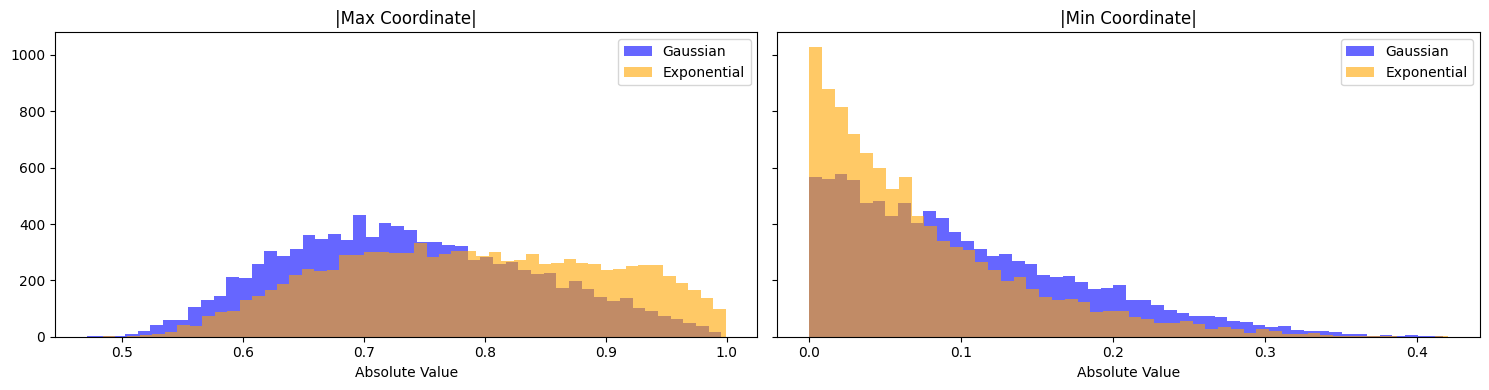

In [19]:
import numpy as np
import matplotlib.pyplot as plt

n = 5  # number of dimensions
samples = 10000

# Sample from N(0,1)
normal_samples = np.random.normal(0, 1, (samples, n))
normal_normed = normal_samples / np.linalg.norm(normal_samples, axis=1, keepdims=True)

# Sample from Exp(1)
exp_samples = np.random.exponential(1e-9, (samples, n))
exp_normed = exp_samples / np.linalg.norm(exp_samples, axis=1, keepdims=True)

# --- Create 1x3 subplot ---
fig, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True)

# |Max coordinate|
axes[0].hist(np.max(np.abs(normal_normed), axis=1), bins=50, alpha=0.6, label='Gaussian', color='blue')
axes[0].hist(np.max(np.abs(exp_normed), axis=1), bins=50, alpha=0.6, label='Exponential', color='orange')
axes[0].set_title('|Max Coordinate|')
axes[0].set_xlabel('Absolute Value')

# |Min coordinate|
axes[1].hist(np.min(np.abs(normal_normed), axis=1), bins=50, alpha=0.6, label='Gaussian', color='blue')
axes[1].hist(np.min(np.abs(exp_normed), axis=1), bins=50, alpha=0.6, label='Exponential', color='orange')
axes[1].set_title('|Min Coordinate|')
axes[1].set_xlabel('Absolute Value')

axes[0].legend()
axes[1].legend()


plt.tight_layout()
plt.show()


## Part 2: Bringing Particles to Life

Now that we have our terrain, we can set up our vegetation. The idea is our particles will be able to move around on our 100 x 100 grid, but first, we need to define the state of a particle. For simplicity, we assume the only kind of plant is trees. Each tree has DNA, which is a convex combination of 5 archetypes, each corresponding to an inhabitable land type in our world. (As a side note, a convex combination means a linear combination where the weights are non-negative and add up to 1. Also we consider ocean as not inhabitable for trees.) Here is the correspondence table of the land types and their ideal tree types. For example, a DNA of $[0.05, 0.05, 0.05, 0.8, 0.05]$ will be a tree well suited to live in the Inland environment.


<div>
  <table>
    <tr>
      <td>
        <img src="images/plant_land_table.png", width=400px>    
      </td>
    </tr>
  </table>
</div>

We will initialize a tree's DNA by sampling each element uniformly from $[0, 1]$ independently and normalizing this vector.

At each time step, a tree may have offpring (seeds) whose DNA will be slightly mutated. The mutation adds a small pertubation vector to the parent's DNA vector. The pertubation vector has each entry sampled uniformly from $[-\sigma, \sigma]$ for some small $\sigma$. Then, we clip each entry of the result to the range $[0, 1]$ and re-normalize.

You do not need to follow the steps above! You are free to design any initialization and mutation scheme that you want to experiment with, but make sure that at each time step, every tree's DNA vector is non-negative and sums to 1.

**TASK** In the following cell, fill out the functions for generating the initial random DNA as well as generating offspring.

(Note: the tests for this lab are just a sanity check for your code and shouldn't be treated as a solid assessment for algorithmic correctness.)

In [20]:
def init_random_dna():
    vec = np.random.uniform(0, 1, 5)
    return vec / np.linalg.norm(vec, ord=1)

In [21]:
grader.check("initialize_random_dna")

initialize_random_dna results: All test cases passed!

In [22]:
def generate_offspring_dna(parent_dna, sigma):
    vec = np.random.uniform(-sigma, sigma, 5)
    pertubation = parent_dna + vec
    pert_clipped = np.clip(pertubation, 0,1)
    offspring = pert_clipped / np.linalg.norm(pert_clipped, ord=1)
    return offspring

In [23]:
grader.check("generate_offspring_dna")

generate_offspring_dna results: All test cases passed!

Now, putting everything together in the tree class.

In [24]:
class Tree(AbstractTree):

    def initialize_random_dna(self):
        self.dna = init_random_dna()
    
    def generate_offspring(self, sigma):
        offspring_dna = generate_offspring_dna(self.dna, sigma)
        return Tree(dna=offspring_dna)

Visualize DNA.

In [25]:
@interact(Shallow=r, Beach=r, Dirt=r, Inland=r, Mountains=r)
def f(Shallow, Beach, Dirt, Inland, Mountains):
    unnormalized_DNA = np.array([Shallow, Beach, Dirt, Inland, Mountains])
    DNA = unnormalized_DNA / np.sum(unnormalized_DNA)
    tree = Tree(DNA)
    visualize_dna(tree)

interactive(children=(FloatSlider(value=0.5, description='Shallow', max=1.0), FloatSlider(value=0.5, descripti…

Visualize mutations over multiple generations of a tree's DNA. Feel free to play with the variance and see how things change.

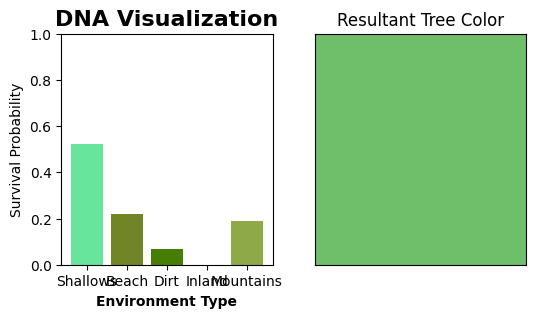

In [26]:
tree = Tree()
var = 0.3
n_steps = 30
for i in range(n_steps):
    clear_output(wait=True)

    fig = visualize_dna(tree)
    if i in [0, n_steps // 2, n_steps - 1]:
        save_fig(fig, f'q2a_frame{i}.png')
    tree = tree.generate_offspring(var)

## Part 3: Defining The Mechanics

Now that we have our tree, we can define the mechanics that govern their survival and reproduction.

- Our world will initially be empty, but at each time step, a tree can magically appear in a square with probability `self.life_prob`, perhaps through an animal bringing over its seed. This is be implemented in `simulate_life_creation`.
- If tree is currently in a square, it survives each time step with some probability. This is implemented in `age_tree`.
- If it survives, it can then also generate a number of offspring. The number of offspring is sampled independently from a binomial distribution with $n=\text{self.max\_seeds}$ and $p=\text{fitness}$. You can change this distribution to play with too! This is implemented in `generate_offspring`.
- Finally, if a bunch of trees are on the same square, they will compete for the square because resources are limited! Each tree $t$ on a square $s$ has an "energy" value that is equal to $\exp(\text{s.comp\_constant} \cdot \text{t.fitness})$. Then, each tree on the square wins with probability proportional to its energy value. This is called the **Boltzmann distribution** and is used in economics to model distribution of resources. 

**TASK** Fill out the following function definitions based on the comments in the later code block.

In [27]:
def can_plant_seed(life_prob):
    # Returns True with probability life_prob, False otherwise
    return np.random.rand() <= life_prob


In [28]:
grader.check("can_plant_seed")

can_plant_seed results: All test cases passed!

In [29]:
def can_terminate_tree(survival_prob):
    # Returns True with probability 1 - survival_prob, False otherwise
    return np.random.rand() <= (1 - survival_prob)

In [30]:
grader.check("can_terminate_tree")

can_terminate_tree results: All test cases passed!

To implement **gen_offspring** and obtain relevant functions, look at **pocket_planet_utils.py** for class definitions and refer to the details in the paragraph above. You're given a Square object in the function definition.

In [31]:
def gen_offspring(square):
    tree_ = square.tree
    env_ = square.env_type
    max_seeds = square.max_seeds
    var = square.mutation_var
    fitness = tree_.calc_fitness(env_)
    num = scipy.stats.binom.rvs(max_seeds, fitness)
    offspring = []
    for n in range(num): 
        offspring.append(tree_.generate_offspring(var))
    return offspring

In [32]:
grader.check("generate_offspring")

generate_offspring results: All test cases passed!

**TASK** Implement the `get_probabilities` function, which takes in a number `comp_constant` and a vector of `fitness` values, and returns a vector of probabilities denoting the probability of each tree winning the competition, as described above. 

The Boltzmann distribution might not admit a simple CDF, and in a future lab, we will discuss how to sample from such a distribution. For now, we have provided the function `sample_boltzmann_distribution` which will sample the probabilities that you have calculated.

In [33]:
def get_probabilities(comp_constant, fitness):
    energies = np.exp(comp_constant * fitness)
    probabilities = energies / np.sum(energies)
    return probabilities

In [34]:
grader.check("sample_boltzmann_distribution")

sample_boltzmann_distribution results: All test cases passed!

Now, the Square class puts everything together.

In [35]:
class Square(AbstractSquare):
    
    def simulate_life_creation(self):
        # Calls self.plant_seed(Tree()) with probability self.life_prob
        can_plant_seed(self.life_prob) and self.plant_seed(Tree())
                        
            
    def age_tree(self):
        # Calls self.terminate_tree() with probability 1-survival_prob
        if not self.contains_tree():
            return
        survival_prob = self.tree.calc_fitness(self.env_type)
        can_terminate_tree(survival_prob) and self.terminate_tree()
        

    def generate_offspring(self):
        # Returns a list of offspring as described above
        if not self.contains_tree():
            return []
        # A square will have a tree and other properties that may prove useful.
        return gen_offspring(self)
    
    
    def sample_boltzmann_distribution(self, fitness, return_dist=False):
        # Creates an (np.)array of probabilities corresponding to each tree's energy value, using the formula from the above blurb
        probabilities = get_probabilities(self.comp_constant, fitness)
        
        if return_dist:
            return probabilities
        winner_index = random.choices(np.arange(0, len(fitness)), probabilities)[0]
        return winner_index

Visualize the evolution of a single tree on our world, and answer the questions below.

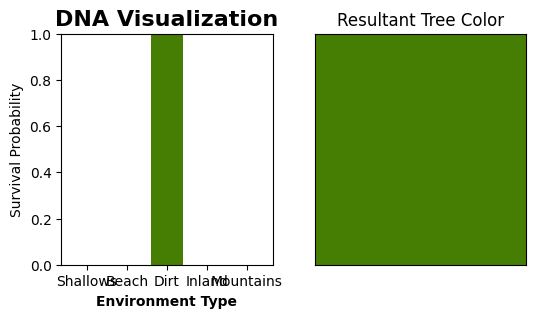

In [36]:
var = 0.5
comp_constant = 1000
    
square = create_secret_square(var, comp_constant, Square)
n_steps = 50

for i in range(n_steps):
    plt.pause(0.1)
    clear_output(wait=True)

    fig = psuedo_env_step(square, Tree)
    if i in [0, n_steps // 2, n_steps - 1]:
        save_fig(fig, f'q3b_frame{i}.png')

<!-- BEGIN QUESTION -->

## TODO: Written Questions
Based on your investigations, answer the following questions:

1) What would you guess is the environment type of the square?
I would guess that the enviornment type must be dirt given that the simulation always converges to an oak tree. In other words, since env_type dictates what probability to grab from the dna to calculate fitness, it would only ever converge to an oak tree if the probability of the dna for the oak tree was highest, thus creating a bias towards oak trees. 

[**MANUAL ANSWER, SUBMIT TO GRADESCOPE SEPARATELY**] 

(Feel free to use this space to draft your answer.)

2) How does mutation variance affect the rate of convergence and the behavior once evolution has reached steady state?
 We can see that as we decrease the variance, from high to low, the time it takes to reach a steady state takes longer. The way this simulation is designed means that higher variance allows tree dna's to span different dna combinations at an incredibly quick rate. As a result, we are more likely to produce a tree with high fitness dna for this predictable environment (e.g. the dirt cell) much quicker than with a low variance. Another way to put it is that once a tree is highly fit for the environment type, it will continously be favored as the best tree in that cell, ultimately omitting the noisier offspring with lower fitness for that environment type. 



[**MANUAL ANSWER, SUBMIT TO GRADESCOPE SEPARATELY**] 

(Feel free to use this space to draft your answer.)

3) In a rapidly changing environment, would we want a high or low mutation rate? What about in a predictable environment?
In a rapidly changing environment, we would want a high mutation rate. This gives offspring a higher chance of producing new DNA combinations that might be better suited when conditions suddenly shift (e.g., from Dirt to Inland). Without variation, the population risks dying out when the old adaptation no longer works.

In a predictable environment, we would want a low mutation rate. Since the environment is stable, the best DNA traits are already known. A low mutation rate preserves these adaptations and avoids wasting energy on harmful variations. Over time, even small mutations are enough to fine-tune survival, but large swings would mostly be disruptive.

[**MANUAL ANSWER, SUBMIT TO GRADESCOPE SEPARATELY**] 
(Feel free to use this space to draft your answer.)
Rate of convergence: A larger competition constant exaggerates fitness differences, making the best tree much more likely to win. This accelerates convergence because one tree quickly dominates. A smaller competition constant softens differences, so weaker trees can still win occasionally, slowing convergence.

At steady state: With a high competition constant, the population is very stable (the best tree almost always wins). With a low competition constant, even less-fit trees sometimes survive, which maintains variation and prevents complete fixation.

[**MANUAL ANSWER, SUBMIT TO GRADESCOPE SEPARATELY**] (Feel free to use this space to draft your answer.)

<!-- END QUESTION -->

## Q4 Bringing It All Together

You're almost done! All that is left is to make our particles be able to move across squares.

- In `simulate_movement`, we want to be able to move a particle from position $i, j$.  To do this, we'll generate`new_coord` as follows:
    1. Start with `coord`, a 2-element vector denoting the particle's current position.
    2. Perturb each coordinate with i.i.d $\text{Normal}(0, \text{var})$ noise.
    3. Clip each coordinate to be within the range `[min_val, max_val]`.
    4. Round each coordinate to the nearest integer.
 <!-- from $\text{Normal}([i,j], var)$, (where $[i, j]$ is a 2-element vector), then clip to `[min_val, max_val]`, and finally round to the nearest integer. -->
- In `spread_seeds`, we'll get new positions for a seeds at $i, j$ by setting the variance for `simulate_movement`. If a square is an ocean, set variance to be `self.waves_var`. Otherwise, set it to be `self.wind_var`.

In [37]:
def get_new_coord(coord, var, min_val, max_val):
    perturb = scipy.stats.norm.rvs(0, var, 2)
    new_coord = coord + perturb 
    new_coord = np.clip(new_coord, min_val, max_val)
    return np.round(new_coord).astype(int)


In [38]:
grader.check("world")

world results: All test cases passed!

Finally, the World implementation.

In [39]:
class World(AbstractWorld):
    def simulate_movement(self, i, j, var):
        coord = np.array([i, j])
        min_val, max_val = 0, self.dim - 1
        
        new_coord = get_new_coord(coord, var, min_val, max_val)
        
        return new_coord[0], new_coord[1]
    
    def spread_seeds(self, i, j):
        square = self.world[i][j]
        trees = square.get_seeds()
        
        if square.is_ocean():
            var = self.waves_var
        else:
            var = self.wind_var
            
        for tree in trees:
            x, y = self.simulate_movement(i, j, var)
            self.world[x][y].plant_seed(tree)

## Congratulations!

You're free! We hope you've enjoyed this evolutionary journey. We highly recommend tinkering with the hyperparameters. After putting in all this work, you might as well get some fun out of it. If you find any cool properties, feel free to write about it below!

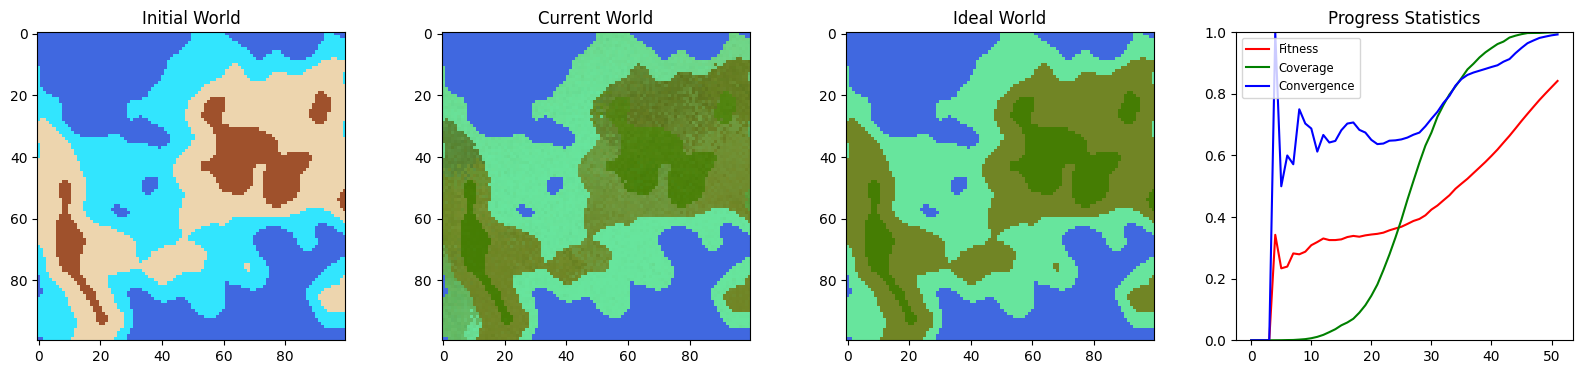

KeyboardInterrupt: 

In [40]:
world = World(generate_world,
              Square,
              dim=100,
              mutation_var=0.03,
              comp_constant=100,
              
              wind_var=2,
              waves_var=5)

n_steps = 70
for i in range(70):
    fig = world.env_step()
    if i in [0, n_steps // 2, n_steps - 1]:
        save_fig(fig, f'q4_frame{i}.png')

## TODO: Written Questions

<!-- BEGIN QUESTION -->

**Question 4a**. When life initially starts to spread across the map, the fitness curve is extremely volatile, but eventually it smooths out. Why is this?
At the start, trees with many different dna profiles appear randomly, so fitness fluctuates a lot as poorly adapted and moderately adapted trees compete for survival. Over time, the trees best suited to each environment type establish themselves. Once these well-adapted trees dominate, the Boltzmann distribution consistently favors them, and the overall fitness curve stabilizes, leading to insignificant variation in fitness. 

[**MANUAL ANSWER, SUBMIT TO GRADESCOPE SEPARATELY**]

(Feel free to use this space to draft your answer.)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 4b**. You might notice that the Coverage progression curve tends to match a sigmoid curve. Give a conjecture as to why this might be.

[**MANUAL ANSWER, SUBMIT TO GRADESCOPE SEPARATELY**]

(Feel free to use this space to draft your answer.)

Coverage looks like a sigmoid because of three phases. Early on, growth is slow as trees with many different DNA profiles compete and most are poorly adapted. Once well-fit trees emerge, they spread rapidly across suitable terrain, leading to the steep middle growth phase. Finally, coverage tapers off as expansion slows — trees compete at the boundaries of environments, and only the best-adapted DNA persists, creating the flattened tail.

<!-- END QUESTION -->

## Submission

Congratulations on completing the lab! Run all the cells in this notebook, save it, and upload this .ipynb file to Gradescope under the autograder assignment. 

Your manual responses will be submitted through the other assignment for this lab on Gradescope. Have a good rest of your week!

## References

1. https://en.wikipedia.org/wiki/Perlin_noise
1. https://flafla2.github.io/2014/08/09/perlinnoise.html
1. https://gamedev.stackexchange.com/questions/23625/how-do-you-generate-tileable-perlin-noise